In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import optuna
import numpy as np
import matplotlib.pyplot as plt

# torch.manual_seed(120)
# np.random.seed(120)
# random.seed(120)

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Global definitions for common parameters
input_size = 5
output_size = 2
epsilon_start = 1.0
epsilon_end = 0.01
gamma = 0.99
num_episodes = 200

# Define DQN models for FFNN, RNN, and LSTM
class FFNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, random_state=42):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim).to(device)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(device)
        self.fc3 = nn.Linear(hidden_dim, out_dim).to(device)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class RNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, layer_num=2, random_state=42):
        super(RNN, self).__init__()
        self.rnnLayer = nn.RNN(in_dim, hidden_dim, layer_num, batch_first=True).to(device)
        self.relu = nn.ReLU()
        self.fcLayer = nn.Linear(hidden_dim, out_dim).to(device)

    def forward(self, x):
        out, _ = self.rnnLayer(x)
        out = self.relu(out[:, -1, :])  # Take the output of the last time step
        out = self.fcLayer(out)
        return out

import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, layer_num=4, random_state=42):
        super(LSTM, self).__init__()
        self.lstmLayer = nn.LSTM(in_dim, hidden_dim, layer_num, batch_first=True, dropout=0.2).to(device)
        self.relu = nn.ReLU()
        self.fcLayer1 = nn.Linear(hidden_dim, hidden_dim).to(device)
        
        # BatchNorm1d with customizable parameters
        self.batch_norm = nn.BatchNorm1d(hidden_dim, momentum=0.9, eps=1e-5).to(device)
        self.fcLayer2 = nn.Linear(hidden_dim, out_dim).to(device)

    def forward(self, x):
        x = x.to(device)
        out, _ = self.lstmLayer(x)
        out = self.relu(out[:, -1, :])  # Take the output of the last time step
        out = self.relu(self.fcLayer1(out))
        if out.size(0) > 1:
            out = self.batch_norm(out)
        out = self.fcLayer2(out)
        return out



# Define a replay buffer to store experience
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return zip(*random.sample(self.buffer, batch_size))

    def __len__(self):
        return len(self.buffer)

# Define the Iterated Prisoner's Dilemma environment
class IteratedPrisonersDilemma:
    def __init__(self):
        self.num_actions = 2
        self.payoff_matrix = np.array([
            [4, -10],
            [10, 0]
        ])

    def step(self, action1, action2):
        reward1 = self.payoff_matrix[action1][action2]
        reward2 = self.payoff_matrix[action2][action1]
        return reward1, reward2

# Function to select an action based on the current state and epsilon-greedy policy
def select_action(state, epsilon, policy_net, output_size):
    if np.random.rand() < epsilon:
        return np.random.randint(output_size)
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            q_values = policy_net(state_tensor)
            return q_values.argmax().item()

# Function to update Q-values using experience replay
def update_q_values(replay_buffer, batch_size, policy_net, target_net, optimizer, gamma):
    if len(replay_buffer) < batch_size:
        return
    states, actions, rewards, next_states = replay_buffer.sample(batch_size)
    states = torch.tensor(states, dtype=torch.float32).view(batch_size, 1, -1).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).view(batch_size, 1, -1).to(device)

    q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = target_net(next_states).max(1)[0].detach()
    expected_q_values = rewards + gamma * next_q_values

    loss = nn.functional.mse_loss(q_values, expected_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Function to train a DQN model using Optuna for hyperparameter optimization
def train_dqn(trial, model_class):
    hidden_size = trial.suggest_int('hidden_size', 64, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epsilon_decay = trial.suggest_uniform('epsilon_decay', 0.995, 0.999)
    target_update = trial.suggest_int('target_update', 5, 20)

    policy_net = model_class(input_size, hidden_size, output_size).to(device)
    target_net = model_class(input_size, hidden_size, output_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer(capacity=10000)
    ipd_env = IteratedPrisonersDilemma()
    total_rewards = []

    for episode in range(num_episodes):
        state = [0, 0, 0, 0, 0]
        total_reward = 0
        for t in range(100):
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode / epsilon_decay)
            action = select_action(state, epsilon, policy_net, output_size)
            opponent_action = state[0]
            reward, opponent_reward = ipd_env.step(action, opponent_action)
            next_state = [action, opponent_action, reward, opponent_reward, t]
            replay_buffer.push(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            update_q_values(replay_buffer, batch_size, policy_net, target_net, optimizer, gamma)
            if t % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())
        total_rewards.append(total_reward)

    avg_reward = np.mean(total_rewards)
    return avg_reward

# Function to optimize a model using Optuna
def optimize_model(model_class):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: train_dqn(trial, model_class), n_trials=50)
    print(f"Best trial: {study.best_trial.params}")
    return study.best_trial.params

# Function to test the model against a fixed strategy
def play_ipd(policy_net, num_episodes, strategy, epsilon=0.0):
    ipd_env = IteratedPrisonersDilemma()
    total_rewards = []
    for episode in range(num_episodes):
        state = [0, 0, 0, 0, 0]
        total_reward = 0
        opponent_last_action = 0
        grim_trigger_active = False
        for t in range(100):
            with torch.no_grad():
                if np.random.rand() < epsilon:
                    action = np.random.randint(output_size)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()

            if strategy == "random":
                opponent_action = np.random.randint(2)
            elif strategy == "tft":
                opponent_action = opponent_last_action
            elif strategy == "grim_trigger":
                if grim_trigger_active:
                    opponent_action = 1
                else:
                    opponent_action = 0
                    if action == 1:
                        grim_trigger_active = True
            elif strategy == "always_cooperate":
                opponent_action = 0
            elif strategy == "always_defect":
                opponent_action = 1

            reward, _ = ipd_env.step(action, opponent_action)
            total_reward += reward

            next_state = [action, opponent_action, reward, 0, t]
            state = next_state
            opponent_last_action = action

        total_rewards.append(total_reward)

    avg_reward = np.mean(total_rewards)
    return avg_reward


Using device: cuda


In [13]:
def test_against_strategies(policy_net, num_episodes):
    strategies = ["random", "tft", "always_cooperate", "always_defect", "grim_trigger"]
    rewards = {}
    for strategy in strategies:
        strategy_rewards = play_ipd(policy_net, num_episodes, strategy, epsilon=0.1)
        avg_reward = np.mean(strategy_rewards)
        rewards[strategy] = avg_reward
        print(f"Average reward against {strategy} strategy: {avg_reward}")
    return rewards

In [14]:
print("Optimizing FFNN...")
# ffnn_params = optimize_model(FFNN)
ffnn_params = {'hidden_size': 64, 'learning_rate': 0.0006389913223567805, 'batch_size': 256, 'epsilon_decay': 0.9959552372459598, 'target_update': 19}

Optimizing FFNN...


In [15]:
print("Optimizing RNN...")
# rnn_params = optimize_model(RNN)
rnn_params = {'hidden_size': 256, 'learning_rate': 0.002733474389577709, 'batch_size': 128, 'epsilon_decay': 0.996321633274378, 'target_update': 8}

Optimizing RNN...


In [16]:
print("Optimizing LSTM...")
# lstm_params = optimize_model(LSTM)
lstm_params = {'hidden_size': 195, 'learning_rate': 0.0001943379119303164, 'batch_size': 128, 'epsilon_decay': 0.9962839771420575, 'target_update': 5}

Optimizing LSTM...


In [17]:
# Define function to train and test final models
def train_final_model(model_class, params):
    hidden_size = params['hidden_size']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epsilon_decay = params['epsilon_decay']
    target_update = params['target_update']

    policy_net = model_class(input_size, hidden_size, output_size)
    target_net = model_class(input_size, hidden_size, output_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer(capacity=10000)
    ipd_env = IteratedPrisonersDilemma()

    for episode in range(num_episodes):
        state = [0, 0, 0, 0, 0]
        total_reward = 0
        for t in range(100):
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode / epsilon_decay)
            action = select_action(state, epsilon, policy_net, output_size)
            opponent_action = state[0]
            reward, opponent_reward = ipd_env.step(action, opponent_action)
            next_state = [action, opponent_action, reward, opponent_reward, t]
            replay_buffer.push(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            update_q_values(replay_buffer, batch_size, policy_net, target_net, optimizer, gamma)
            if t % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())
        print(f"Episode {episode + 1}, Total Reward: {total_reward}")

    rewards = test_against_strategies(policy_net, num_episodes=100)
    return rewards

In [18]:
def plot_rewards(rewards_dict):
    strategies = ["random", "tft", "always_cooperate", "always_defect", "grim_trigger"]
    models = list(rewards_dict.keys())

    fig, ax = plt.subplots()
    x = np.arange(len(strategies))
    width = 0.25

    for i, model in enumerate(models):
        rewards = [rewards_dict[model][strategy] for strategy in strategies]
        ax.bar(x + i * width, rewards, width, label=model)

    ax.set_xlabel('Strategy')
    ax.set_ylabel('Average Reward')
    ax.set_title('Average Rewards by Model and Strategy')
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(strategies)
    ax.legend()

    plt.show()

In [19]:
ffnn_rewards = train_final_model(FFNN, ffnn_params)
rnn_rewards = train_final_model(RNN, rnn_params)
lstm_rewards = train_final_model(LSTM, lstm_params)

rewards_dict = {
    'FFNN': ffnn_rewards,
    'RNN': rnn_rewards,
    'LSTM': lstm_rewards
}

Episode 1, Total Reward: 116
Episode 2, Total Reward: 8
Episode 3, Total Reward: 14
Episode 4, Total Reward: 20
Episode 5, Total Reward: 368
Episode 6, Total Reward: 400
Episode 7, Total Reward: 392
Episode 8, Total Reward: 352
Episode 9, Total Reward: 304
Episode 10, Total Reward: 280
Episode 11, Total Reward: 324
Episode 12, Total Reward: 336
Episode 13, Total Reward: 344
Episode 14, Total Reward: 372
Episode 15, Total Reward: 388
Episode 16, Total Reward: 316
Episode 17, Total Reward: 320
Episode 18, Total Reward: 328
Episode 19, Total Reward: 344
Episode 20, Total Reward: 364
Episode 21, Total Reward: 376
Episode 22, Total Reward: 376
Episode 23, Total Reward: 388
Episode 24, Total Reward: 388
Episode 25, Total Reward: 380
Episode 26, Total Reward: 400
Episode 27, Total Reward: 400
Episode 28, Total Reward: 392
Episode 29, Total Reward: 392
Episode 30, Total Reward: 400
Episode 31, Total Reward: 380
Episode 32, Total Reward: 400
Episode 33, Total Reward: 400
Episode 34, Total Rewar

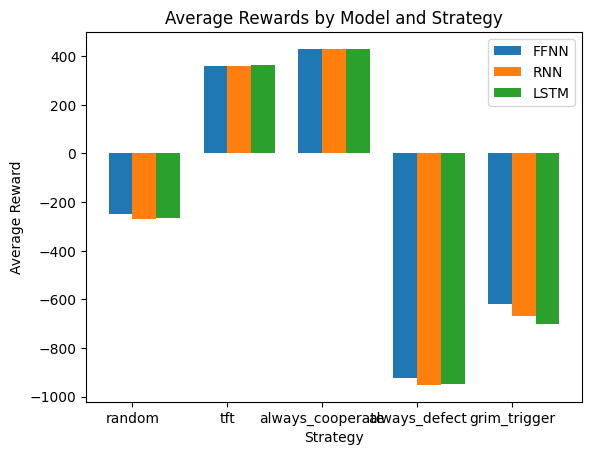

In [20]:
import matplotlib.pyplot as plt
plot_rewards(rewards_dict)

In [21]:
print(rewards_dict)

{'FFNN': {'random': -248.32, 'tft': 358.9, 'always_cooperate': 429.58, 'always_defect': -923.3, 'grim_trigger': -619.16}, 'RNN': {'random': -268.92, 'tft': 361.18, 'always_cooperate': 428.56, 'always_defect': -951.4, 'grim_trigger': -666.7}, 'LSTM': {'random': -265.92, 'tft': 363.22, 'always_cooperate': 429.94, 'always_defect': -947.7, 'grim_trigger': -701.56}}


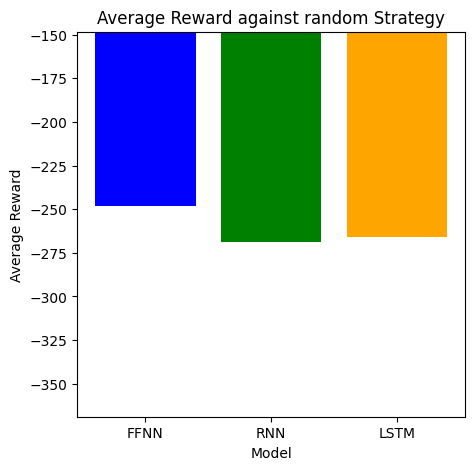

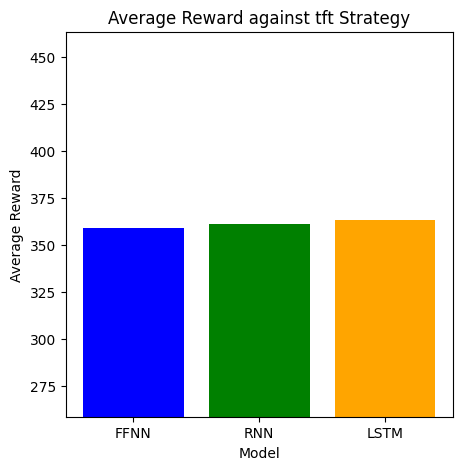

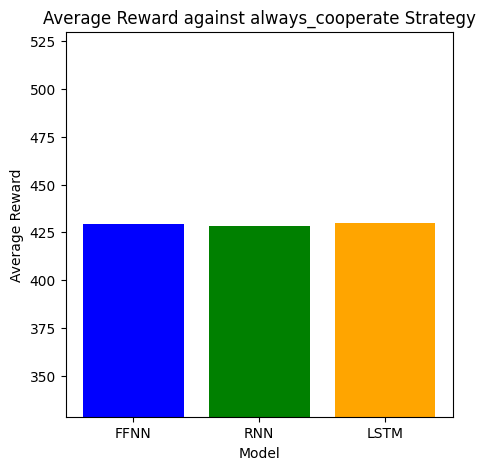

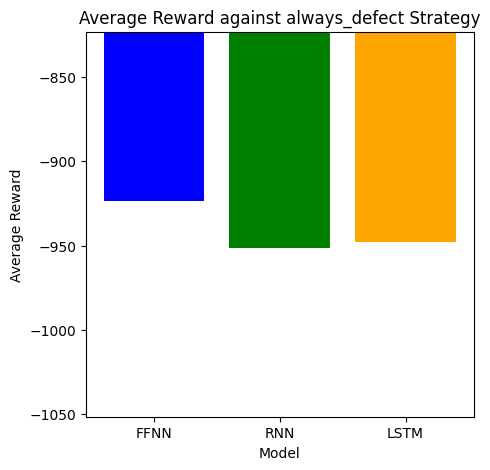

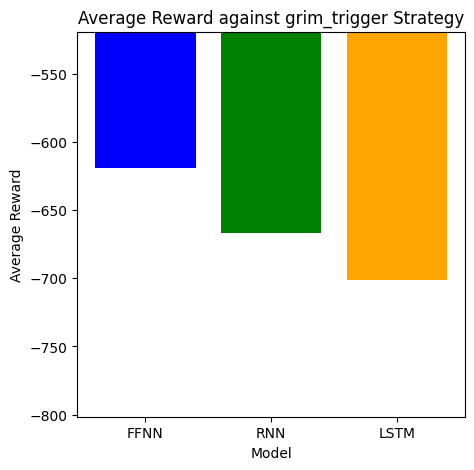

In [22]:
def plot_individual_strategies(rewards_dict):
    strategies = list(next(iter(rewards_dict.values())).keys())
    models = list(rewards_dict.keys())

    for strategy in strategies:
        avg_rewards = [rewards_dict[model][strategy] for model in models]

        plt.figure(figsize=(5, 5))
        plt.bar(models, avg_rewards, color=['blue', 'green', 'orange'])
        plt.xlabel('Model')
        plt.ylabel('Average Reward')
        plt.title(f'Average Reward against {strategy} Strategy')
        plt.ylim(min(avg_rewards) - 100, max(avg_rewards) + 100)
        plt.show()

# Plot the individual graphs
plot_individual_strategies(rewards_dict)